In [8]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json

In [49]:
city = 'Kansas City'
state = 'Missouri'

states ={ 
  "Alabama": "01", "Alaska": "02",
  "Arizona": "04",
  "Arkansas": "05",
  "California": "06",
  "Colorado": "08",
  "Delaware": "10",
  "District of Columbia": "11",
  "Connecticut": "09",
  "Florida": "12",
  "Georgia": "13",
  "Idaho": "16",
  "Hawaii": "15",
  "Illinois": "17",
  "Indiana": "18",
  "Iowa": "19",
  "Kansas": "20",
  "Kentucky": "21",
  "Louisiana": "22",
  "Maine": "23",
  "Maryland": "24",
  "Massachusetts": "25",
  "Michigan": "26",
  "Minnesota": "27",
  "Mississippi": "28",
  "Missouri": "29",
  "Montana": "30",
  "Nebraska": "31",
  "Nevada": "32",
  "New Hampshire": "33",
  "New Jersey": "34",
  "New Mexico": "35",
  "New York": "36",
  "North Carolina": "37",
  "North Dakota": "38",
  "Ohio": "39",
  "Oklahoma": "40",
  "Oregon": "41",
  "Pennsylvania": "42",
  "Rhode Island": "44",
  "South Carolina": "45",
  "South Dakota": "46",
  "Tennessee": "47",
  "Texas": "48",
  "Vermont": "50",
  "Utah": "49",
  "Virginia": "51",
  "Washington": "53",
  "West Virginia": "54",
  "Wisconsin": "55",
  "Wyoming": "56",
  "Puerto Rico": "72"
}

In [50]:
city = f'{city} city'
state_num = states[state]
full_city = f'{city}, {state}'
county_nums = []
county_query = ''
tracts = []
pops = 'B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B03001_003E'
demogs = {
  'white': {},
  'black': {},
  'native': {},
  'asian': {},
  'pacific': {},
  'hispanic': {}
}




In [51]:
url = f'https://api.census.gov/data/2019/acs/acs5?get=NAME&for=place:*&in=state:{stateNum}'

response = requests.get(url).json()
# print(json.dumps(response, indent=4, sort_keys=True))

for r in response:
    if r[0] == full_city:
        url = f'https://api.census.gov/data/2019/acs/acs5?get=NAME&for=county%20(or%20part):*&in=state:{stateNum}%20place:{r[2]}'
        break
        
response = requests.get(url).json()

for r in response:
    if r[0] != 'NAME': 
        county_nums.append(r[3])

for n in range(0, len(county_nums)):
    if n == 0:
        county_query = county_nums[n]
    else:
        county_query = county_query + f',{county_nums[n]}'


        
url = f'https://api.census.gov/data/2019/acs/acs5?get=NAME,{pops}&for=tract:*&in=county:{county_query}&in=state:{state_num}'

response = requests.get(url).json()

for r in response: 
    print(r)




['NAME', 'B02001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 'B02001_006E', 'B03001_003E', 'state', 'county', 'tract']
['Census Tract 73, Jackson County, Missouri', '2582', '214', '0', '153', '0', '80', '29', '095', '007300']
['Census Tract 76, Jackson County, Missouri', '345', '1666', '0', '0', '0', '144', '29', '095', '007600']
['Census Tract 79, Jackson County, Missouri', '294', '3256', '20', '10', '0', '47', '29', '095', '007900']
['Census Tract 102.01, Jackson County, Missouri', '1094', '1167', '21', '21', '39', '94', '29', '095', '010201']
['Census Tract 83, Jackson County, Missouri', '2317', '67', '0', '16', '0', '117', '29', '095', '008300']
['Census Tract 91, Jackson County, Missouri', '3157', '294', '11', '91', '0', '205', '29', '095', '009100']
['Census Tract 100.01, Jackson County, Missouri', '1371', '210', '0', '65', '0', '74', '29', '095', '010001']
['Census Tract 110, Jackson County, Missouri', '3872', '476', '36', '28', '0', '776', '29', '095', '011000']
['Censu

In [24]:
ccvi = pd.read_csv('../resources/ccvi_nonulls.csv')
ccvi


,FIPS,stateName,countyName,ccvi,theme1,theme2,theme3,theme4,theme5,theme6,theme7
0,1001020100,ALABAMA,Autauga,0.441972,0.458336,0.377478,0.170811,0.841617,0.966294,0.209805,0.287591
1,1001020200,ALABAMA,Autauga,0.742619,0.562935,0.584587,0.683826,0.768947,0.982399,0.209805,0.427810
2,1001020300,ALABAMA,Autauga,0.778072,0.245094,0.645024,0.472226,0.863762,0.953086,0.724817,0.439041
3,1001020400,ALABAMA,Autauga,0.362727,0.023280,0.370119,0.192050,0.977978,0.894654,0.209805,0.425573
4,1001020500,ALABAMA,Autauga,0.816600,0.319725,0.421440,0.764060,0.753240,0.978307,0.749454,0.497597
...,...,...,...,...,...,...,...,...,...,...,...
72177,56043000200,WYOMING,Washakie,0.193098,0.632400,0.106362,0.792014,0.669875,0.126091,0.259923,0.008196
72178,56043000301,WYOMING,Washakie,0.288511,0.536803,0.358751,0.539916,0.400654,0.199599,0.259923,0.589599
72179,56043000302,WYOMING,Washakie,0.574666,0.804595,0.349800,0.613380,0.701398,0.137185,0.815509,0.273972
72180,56045951100,WYOMING,Weston,0.112481,0.476381,0.238316,0.834326,0.559188,0.149020,0.037122,0.008224


In [25]:
ccvi['FIPS'] = ccvi['FIPS'].apply(lambda x: str(x)[:5])

#!
ccvi = pd.DataFrame(ccvi.groupby('FIPS')['ccvi'].mean())
#!

ccvi = ccvi.reset_index()
ccvi = ccvi.rename(columns={'FIPS': 'county_fips'})

ccvi

,county_fips,ccvi
0,10001,0.373740
1,10003,0.290547
2,10005,0.286698
3,10010,0.618398
4,10030,0.482349
...,...,...
3168,90119,0.007052
3169,90135,0.066665
3170,90138,0.055681
3171,90158,0.338784


In [26]:
# # drop the null rows
# ccvi = ccvi.dropna()
# ccvi.set_index('FIPS', inplace=True)
# ccvi

# ccvi.to_csv(r'../resources/ccvi_nonulls.csv')

In [27]:
# URL for GET requests to retrieve vehicle data
url = "https://data.cdc.gov/resource/n8mc-b4w4.json?$limit=5000&$offset=0&death_yn=No"


# Pretty print JSON for all launchpads
response = requests.get(url).json()
print(json.dumps(response, indent=4, sort_keys=True))

cases = pd.DataFrame(response)
cases

#*
cases = cases.loc[cases['county_fips_code'] != 'NA', :]
#*


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
cases

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,case_positive_specimen,underlying_conditions_yn,case_onset_interval
0,2020-11,KY,21,MUHLENBERG,21177,18 to 49 years,NA,NA,NA,Missing,Missing,Laboratory-confirmed case,Missing,No,Missing,No,NaN,NaN,NaN
1,2021-01,NY,36,COLUMBIA,36021,0 - 17 years,Female,NA,NA,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,0.0,NaN,NaN
2,2021-03,NC,37,COLUMBUS,37047,0 - 17 years,Female,NA,NA,Missing,Missing,Probable Case,Unknown,Unknown,Unknown,No,0.0,NaN,NaN
3,2021-02,NH,33,COOS,33007,0 - 17 years,Female,NA,NA,Missing,Missing,Laboratory-confirmed case,Asymptomatic,Unknown,Unknown,No,NaN,Yes,NaN
4,2020-12,MN,27,CROW WING,27035,18 to 49 years,Female,Unknown,Missing,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2020-11,MT,30,FLATHEAD,30029,18 to 49 years,Female,White,Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Missing,No,Missing,No,NaN,NaN,NaN
4996,2020-06,OR,41,LINCOLN,41041,18 to 49 years,Female,White,Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No,NaN,NaN,0.0
4997,2020-12,NJ,34,WARREN,34041,18 to 49 years,Female,White,Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No,NaN,NaN,0.0
4998,2020-07,NC,37,NASH,37127,18 to 49 years,Male,White,Hispanic/Latino,Missing,Yes,Laboratory-confirmed case,Symptomatic,No,Unknown,No,0.0,NaN,NaN


In [29]:
case_counts = pd.DataFrame(cases['county_fips_code'].value_counts())

case_counts = case_counts.reset_index()
case_counts = case_counts.rename(columns={'index': 'county_fips', 'county_fips_code': 'case_count'})
case_counts = pd.merge(case_counts, ccvi, on='county_fips')

case_counts



,county_fips,case_count,ccvi
0,55045,9,0.198222
1,18149,9,0.484989
2,21043,9,0.610594
3,34041,9,0.284570
4,23007,9,0.108437
...,...,...,...
591,12003,1,0.723397
592,47157,1,0.698308
593,39061,1,0.539681
594,55109,1,0.135755


In [30]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model

LinearRegression()

In [31]:
X = case_counts['ccvi'].values.reshape(-1, 1)
y = case_counts['case_count'].values.reshape(-1, 1)

# import necessary dependencies
from sklearn.model_selection import train_test_split

# create split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


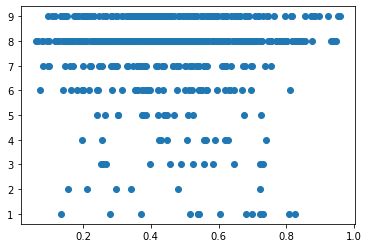

In [77]:
plt.scatter(X, y)

In [79]:
model.fit(X_train, y_train)

model.score(X_test, y_test)


-0.004580151294978574

In [ ]:
model.predict()

# Quantifying Linear Regression

Create a model to quantify

In [1]:
# Import dependencies
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

# Generate some data
X, y = make_regression(n_samples=20, n_features=1, random_state=0, noise=4, bias=100.0)

# Create a linear model
model = LinearRegression()

# Fit (Train) our model to the data
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Quantifying our Model

* Mean Squared Error (MSE)

* R2 Score

There are a variety of ways to quantify the model, but MSE and R2 are very common

In [2]:
from sklearn.metrics import mean_squared_error, r2_score

# Use our model to predict a value
predicted = model.predict(X)

# Score the prediction with mse and r2
mse = mean_squared_error(y, predicted)
r2 = r2_score(y, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 11.933040779746149
R-squared (R2 ): 0.903603363418708


A "good" MSE score will be close to zero while a "good" [R2 Score](https://en.wikipedia.org/wiki/Coefficient_of_determination) will be close to 1.

R2 Score is the default scoring for many of the Sklearn models

In [4]:
# Overall Score for the model
model.score(X, y)

0.90360336341870795

## Validation

We also want to understand how well our model performs on new data. 

One approach for this is to split your data into a training and testing dataset.

You fit (train) the model using training data, and score and validate your model using the testing data.

This train/test splitting is so common that Sklearn provides a mechanism for doing this. 

## Testing and Training Data

In order to quantify our model against new input values, we often split the data into training and testing data. The model is then fit to the training data and scored by the test data. Sklean pre-processing provides a library for automatically splitting up the data into training and testing

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Train the model using the training data

In [6]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

And score the model using the unseen testing data

In [7]:
model.score(X_test, y_test)

0.92525224350441038

## Your Turn!